# MobileNet

In [2]:
import numpy as np
import keras
from keras import backend as k
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [3]:
mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 70s 4us/step


C:\Users\THI\Anaconda3\lib\site-packages\keras\utils\conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [13]:
def prepare_image(file):
    img_path = 'MobileNet-inference-images/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

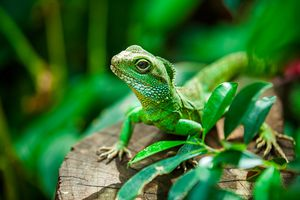

In [14]:
from IPython.display import Image
Image(filename='MobileNet-inference-images/1.PNG', width=300, height=200)

In [15]:
preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

40960/35363 [==================================] - 0s 0us/step


[[('n01682714', 'American_chameleon', 0.56089264),
  ('n01693334', 'green_lizard', 0.24254999),
  ('n01694178', 'African_chameleon', 0.110705934),
  ('n01688243', 'frilled_lizard', 0.05166591),
  ('n01677366', 'common_iguana', 0.018397134)]]

In [ ]:
Image(filename='MobileNet-inference-images/1.PNG', width=300, height=200)

# Fine-tune MobileNet on cats and dogs

## Image preparation

In [4]:
train_path = 'cats-and-dogs/train'
valid_path = 'cats-and-dogs/valid'
test_path = 'cats-and-dogs/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224), classes=['dog','cat'],batch_size=10) 
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), classes=['dog','cat'],batch_size=4) 
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224), classes=['dog','cat'],batch_size=10, shuffle = False) 

Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.



## Modify Model

In [6]:
mobile = keras.applications.mobilenet.MobileNet()

In [7]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_11 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_11_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_11 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
__________

In [8]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

conv_dw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_11_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_11 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_11_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pad_12 (ZeroPadding2D)  (None, 15, 15, 512)       0         
_________________________________________________________________
conv_dw_12 (DepthwiseConv2D) (None, 7, 7, 512)         4608      
_________________________________________________________________
conv_dw_12_bn (BatchNormaliz (None, 7, 7, 512)         2048      
__________

In [10]:
for layer in model.layers[:-5]:
    layer.trainable = False

# Train the model

In [11]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics =['accuracy'])

In [12]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=30, verbose=2)

Epoch 1/30
 - 37s - loss: 0.9427 - acc: 0.5500 - val_loss: 0.7630 - val_acc: 0.5000
Epoch 2/30
 - 36s - loss: 0.3129 - acc: 0.8250 - val_loss: 0.4055 - val_acc: 0.7500
Epoch 3/30
 - 36s - loss: 0.1449 - acc: 0.9500 - val_loss: 0.3091 - val_acc: 0.8750
Epoch 4/30
 - 35s - loss: 0.1042 - acc: 0.9750 - val_loss: 0.2903 - val_acc: 0.7500
Epoch 5/30
 - 35s - loss: 0.0084 - acc: 1.0000 - val_loss: 0.4011 - val_acc: 0.7500
Epoch 6/30
 - 37s - loss: 0.0101 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.7500
Epoch 7/30
 - 36s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.1317 - val_acc: 0.8750
Epoch 8/30
 - 36s - loss: 0.0151 - acc: 1.0000 - val_loss: 0.2282 - val_acc: 0.7500
Epoch 9/30
 - 36s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1107 - val_acc: 0.8750
Epoch 10/30
 - 35s - loss: 0.0080 - acc: 1.0000 - val_loss: 0.2786 - val_acc: 0.8750
Epoch 11/30
 - 35s - loss: 0.0113 - acc: 1.0000 - val_loss: 0.2637 - val_acc: 0.8750
Epoch 12/30
 - 35s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.1815 - val_a

# Predict cats and dogs

In [13]:
test_labels = test_batches.classes

In [14]:
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [15]:
test_batches.class_indices

{'dog': 0, 'cat': 1}

In [16]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [19]:
test_batches.class_indices

{'dog': 0, 'cat': 1}

Confusion matrix, without normalization
[[5 0]
 [0 5]]


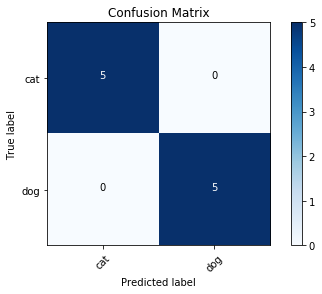

In [20]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Fine-tune MobileNet on sign language digits

### Image preparation

Dataset: https://github.com/SaadAhmed-96/Sign-Language-Digits-Dataset

* 10 classes (digits 0-9)
* Class Data
    * Class 0 205 images
    * Class 1 206 images
    * Class 2 206 images
    * Class 3 206 images
    * Class 4 207 images
    * Class 5 207 images
    * Class 6 207 images
    * Class 7 206 images
    * Class 8 206 images
    * Class 9 204 images

In [21]:
# Save files to sign language Digits Dataset Directory (which resides in current directory where notebook is saved)
# Create train, valid, test folders in sign language digits Dataset

%cd Sign-Language-Digits-Dataset
%mkdir train
%mkdir valid
%mkdir test

C:\Users\THI\Sign-Language-Digits-Dataset


In [28]:
# Move all class directories with images in to train/
%mv 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/ train/

UsageError: Line magic function `%mv` not found.


In [29]:
# make class directories for valid and test data sets
%cd valid
%mkdir 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/ 

%cd ../test
%mkdir 0/ 1/ 2/ 3/ 4/ 5/ 6/ 7/ 8/ 9/ 

C:\Users\THI\Sign-Language-Digits-Dataset\valid
C:\Users\THI\Sign-Language-Digits-Dataset\test


The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [31]:
%%bash
cd ../train
for ((i=0; i <=9; i++)); do
    a=$(find $i/ -type f | shuf -n 30)
    mv $a ../valid/$i/
    b=$(find $i/ -type f | shuf -n 5)
    mv $b ../test/$i/
done

In [33]:
# Move back into current notebook directory
%cd ../..

C:\Users\THI


In [39]:
train_path = 'Sign-Language-Digits-Dataset/train'
valid_path = 'Sign-Language-Digits-Dataset/valid'
test_path = 'Sign-Language-Digits-Dataset/test'

In [40]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path, target_size=(224,224),batch_size=10) 
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path, target_size=(224,224),batch_size=10) 
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path, target_size=(224,224),batch_size=10, shuffle = False) 

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## Modify Model

In [41]:
mobile = keras.applications.mobilenet.MobileNet()

C:\Users\THI\Anaconda3\lib\site-packages\keras\utils\conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [42]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

conv_dw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_11 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_11_relu (ReLU)       (None, 14, 14, 512)       0         
__________

In [43]:
x = mobile.layers[-6].output
predictions = Dense(10, activation='softmax')(x)

In [44]:
model = Model(inputs=mobile.input, outputs=predictions)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

conv_dw_10 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_11 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_11_bn (BatchNormaliz (None, 14, 14, 512)       2048      
__________

In [46]:
for layer in model.layers[:-23]:
    layer.trainable = False

## Train the model

In [47]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics =['accuracy'])

In [48]:
model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=60, verbose=2)

Epoch 1/60
 - 176s - loss: 2.3284 - acc: 0.2667 - val_loss: 2.8856 - val_acc: 0.1000
Epoch 2/60


KeyboardInterrupt: 

## Predict sign language digits

In [ ]:
test_labels = test_batches.classes

In [ ]:
predictions = model.predict_generator(test_batches, steps=5, verbose=0)

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['0', '1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')